# RRT Planning for the KUKA iiwa

We will continue working with the KUKA iiwa arm that you simulated in PyBullet on HW1. Now that we have a collision detection function and a way to query the configuration space regions, we can implement sampling-based motion planning. Let's first set up the environment as we did previously.

In [1]:
import numpy as np
import numpy.typing as npt
from matplotlib import pyplot as plt
from matplotlib import animation
from mpl_toolkits import mplot3d
import pybullet as p
import pybullet_data

pybullet build time: Nov 28 2023 23:48:36


In [2]:
# Animation settings
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 90
plt.ioff()

sim_id = p.connect(p.DIRECT)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetSimulation()

In [3]:
# Load environment objects
plane_id=p.loadURDF('plane.urdf',
            physicsClientId=sim_id)
robot_id=p.loadURDF("kuka_iiwa/model.urdf",
            basePosition=[0,0,0],
            baseOrientation=p.getQuaternionFromEuler([0,0,0]),
            useFixedBase=True,
            physicsClientId=sim_id,
            globalScaling=1,
            flags=p.URDF_USE_IMPLICIT_CYLINDER)
cube_id=p.loadURDF('cube.urdf',
            basePosition=[0.5, 0, 0.5],
            physicsClientId=sim_id,
            globalScaling=0.2)
sphere_id=p.loadURDF('sphere2.urdf',
            basePosition=[0, 0.5, 0.5],
            physicsClientId=sim_id,
            globalScaling=0.2)

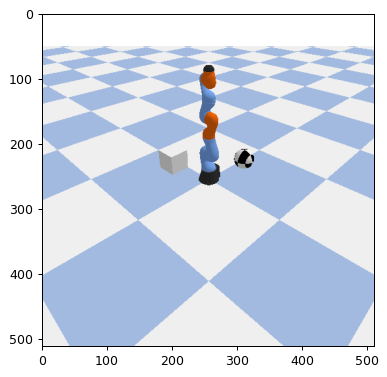

In [4]:
# Show the environment
def showImage(cameraPos=[2, 2, 2]):
    viewMatrix = p.computeViewMatrix(
                cameraEyePosition=cameraPos,
                cameraTargetPosition=[0, 0, 0],
                cameraUpVector=[0, 0, 1])
    projectionMatrix = p.computeProjectionMatrixFOV(
                fov=60.0,
                aspect=1.0,
                nearVal=0.1,
                farVal=10)
    width, height, rgbImg, depthImg, segImg = p.getCameraImage(
                width=512,
                height=512,
                viewMatrix=viewMatrix,
                projectionMatrix=projectionMatrix)
    plt.imshow(rgbImg)
showImage()
plt.show()

We are also including some of the functions that you wrote or used in HW1. Some have been modified for this assignment.

In [5]:
def setRobotPos(q):
    for i in range(len(q)):
        p.resetJointState(robot_id, i, q[i])

def is_collision(q):
    setRobotPos(q)
    p.performCollisionDetection(physicsClientId=sim_id)
    all_contact_points = [cp for cp in p.getContactPoints(bodyA=robot_id) \
                          if cp[1] != plane_id and cp[2] != plane_id and cp[8] < 0]
    return len(all_contact_points) > 0

In [6]:
def visualize_cspace(start, goal, path, tree, num_samples=5000):
    obs_space = np.array([0,0])
    free_space = np.array([0,0])
    
    for i in range(num_samples):
        q = JOINT_LIMITS[0:2] * 2 * (np.random.random(2) - 0.5)
        if is_collision(q):
            obs_space = np.vstack((obs_space, q))
        else:
            free_space = np.vstack((free_space, q))

    plt.cla()
    plt.scatter(obs_space[1:,0], obs_space[1:,1], color='r')
    plt.scatter(free_space[1:,0], free_space[1:,1], color='lightskyblue')

    for node, parent in tree.items():
        if parent is not None:
            coords = [node[0], parent[0], node[1], parent[1]]
            for i in range(4):
                if coords[i] < -np.pi: coords[i] += 2 * np.pi
                if coords[i] > np.pi: coords[i] -= 2 * np.pi
            if coords[0]*coords[1] > -6 and coords[2]*coords[3] > -6:            
                plt.plot(coords[:2], coords[2:], color='navy')   

    plt.scatter([start[0]], [start[1]], marker='x', s=100, color='green', label='start', zorder=2)
    plt.scatter([goal[0]], [goal[1]], marker='+', s=100, color='yellow', label='goal', zorder=2)

    if path:
        path = np.array(path)
        path[np.where(path < -np.pi)] += 2 * np.pi
        path[np.where(path > np.pi)] -= 2 * np.pi 
        plt.scatter(path[:,0], path[:,1], marker='o', color='darkgreen', label='path')
        
    plt.xlabel('theta0')
    plt.ylabel('theta1')
    plt.legend(loc='upper left')
    plt.show()


def plot_path(path):
    if not path:
        print("no path found")
        return

    positions = np.zeros((len(path), 3))
    for i in range(len(path)):
        setRobotPos(path[i])
        position, _ = p.getLinkState(robot_id, len(path[i])-1)[:2]
        positions[i] = position

    fig = plt.figure()
    ax = plt.axes(projection='3d') 
    ax.plot3D(positions[:,0], positions[:,1], positions[:,2])
    ax.scatter3D(positions[0,0], positions[0,1], positions[0,2], marker='x', s=100, color='green', label='start', zorder=2)
    ax.scatter3D(positions[-1,0], positions[-1,1], positions[-1,2], marker='+', s=100, color='yellow', label='goal', zorder=2)        
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('workspace trajectory')
    plt.show()


def animate_path(path):
    if not path:
        print("no path found")
        return
            
    fig, ax = plt.subplots()
    def animate(frame):
        plt.cla()
        setRobotPos(path[frame])
        showImage()
    return animation.FuncAnimation(fig, animate, frames=len(path))

## Part 1: Wraparound Projection (4 pts)

We will later define a global NumPy array variable `JOINT_LIMITS` of size 7 (number of joints). Its values can range between $0$ and $\pi$; a joint with a limit of $0$ means that it must remain fixed at $0$, while a limit of $\pi$ means that it effectively has no limit. More generally, $|q_i|$ must always be less than or equal to its joint limit.

`JOINT_LIMITS` will determine how we compute distances in the robot's C-space. If a joint has a limit less than $\pi$, then we can compute the distance between two configurations using a Euclidean metric, e.g. $L_1$. If a joint has no limit (`JOINT_LIMITS[i] == np.pi`), then we need to use the $\mathbb S^1$ metric.

We will implement this idea with `wraparound_projection()`, which takes two configuration arrays $q_0$ and $q_1$ and returns the *wraparound projection* $q'$ of $q_1$, relative to $q_0$. If joint $i$ has no limit and $2\pi - |q_1[i]-q_0[i]| < |q_1[i]-q_0[i]|$, then

$$q'[i] = \begin{cases} q_1[i] - 2\pi, \text{ if } q_1[i] > q_0[i] \\ q_1[i] + 2\pi,  \text{ if } q_1[i] < q_0[i] \end{cases}$$

Otherwise, we should just have $q'[i] = q_1[i]$.

In [7]:
def wraparound_projection(q0: npt.ArrayLike, q1: npt.ArrayLike) -> npt.ArrayLike:
    """
    Input:
    - q0: joint configuration, in radians
    - q1: joint configuration, in radians
    Output:
    - The "wraparound projection" of q1 (see description above)
    """
    q_prime = np.zeros(len(q1)) 
    bool_arr = 2*np.pi - np.abs(q1-q0) < np.abs(q1-q0)

    for j in range (0, len(JOINT_LIMITS)):
        if JOINT_LIMITS[j] != np.pi:
            bool_arr[j] = False
    for i in range (0, len(bool_arr)):
        if not bool_arr[i]: q_prime[i] = q1[i]
        else:
            if q1[i] > q0[i]: q_prime[i] = q1[i] - (2 * np.pi)
            elif q1[i] < q0[i]:  q_prime[i] = q1[i] + (2 * np.pi)
    return q_prime

In [8]:
start_config = np.array([np.pi * 2 / 3, -np.pi / 2, 0, 0, 0, 0, 0])
goal_config = np.array([np.pi / 2, np.pi * 5 / 8, 0, 0, 0, 0, 0])

JOINT_LIMITS = np.array([np.pi * 3 / 4, np.pi * 2 / 3, 0, 0, 0, 0, 0])
assert((wraparound_projection(start_config, goal_config) == goal_config).all())

JOINT_LIMITS = np.pi * np.ones(7)
assert((wraparound_projection(start_config, goal_config) == np.array([np.pi / 2, -np.pi * 11 / 8, 0, 0, 0, 0, 0])).all())

## Part 2: Edge Collision Detector (4 pts)

Next, we need a segment collision detector that can be test whether the shortest path between two configurations is collision-free. Implement `valid_edge()`, which takes two arrays of joint configurations and the number of configurations to sample evenly between them. 

Again, it is possible that the shortest path between $q_0$ and $q_1$ actually "wraps around", so $q_1$ should be transformed into its wraparound projection first $q'$. Then you can sample between $q_0$ and $q'$; return `True` if all sampled configurations are collision-free and `False` otherwise.

In [9]:
def valid_edge(q0: npt.ArrayLike, q1: npt.ArrayLike, num_steps:int = 5) -> bool:
    """
    Input:
    - q0: joint configuration, in radians
    - q1: joint configuration, in radians
    - num_steps: number of configurations to be sampled evenly between q0 and q1
    Output:
    - True if all configurations sampled between q0 and q1 are collision-free. 
        False otherwise.
    """
    q_prime = wraparound_projection(q0, q1)
    increments = np.linspace(q0, q_prime, num_steps, endpoint=False)
    for increment in increments:
        if is_collision(increment): return False
    if is_collision(q1):return False
    return True
    
    

In [10]:
start_config = np.array([np.pi * 2 / 3, -np.pi / 2, 0, 0, 0, 0, 0])
goal_config = np.array([np.pi / 2, np.pi * 5 / 8, 0, 0, 0, 0, 0])

JOINT_LIMITS = np.array([np.pi * 3 / 4, np.pi * 2 / 3, 0, 0, 0, 0, 0])
assert not valid_edge(start_config, goal_config)

JOINT_LIMITS = np.pi * np.ones(7)
assert valid_edge(start_config, goal_config)

## Part 3: RRT Helper Functions (8 pts)

To make the RRT implementation easier, we will first implement the following two helper methods.

- `qnear_idx()` is given a list of configurations and a query configuration `qrand`. We want to find the closest neighbor to `qrand` in the given list and return its index. You can do so by finding the wraparound projection of `qrand` relative to each candidate configuration, and then computing their $L_1$ (or any other Euclidean) distance.

- `compute_qnew()` is given a reference configuration `qnear`, a random configuration `qrand`, and a `step_size`. If the distance between the two configurations is less than `step_size` then `qrand` can be returned directly. Otherwise, we should compute a configuration between `qnear` and `qrand` at a distance of `step_size` away from `qnear`. Remember to consider wraparound projections.

In [11]:
def qnear_idx(V: list, qrand: npt.ArrayLike) -> int:
    """
    Input:
    - V: list of joint configurations
    - qrand: joint configuration, in radians
    Output:
    - Integer index of closest configuration in V to qrand
    """
    nearest_neighbor = None
    min_dist = np.inf
    for i in range (0, len(V)):
        q_rand_p = wraparound_projection(V[i], qrand)
        dist = np.linalg.norm(q_rand_p-V[i], 1)
        if dist < min_dist:
            min_dist = dist
            nearest_neighbor = i
    return nearest_neighbor
    

In [12]:
def compute_qnew(qnear: npt.ArrayLike, qrand: npt.ArrayLike, step_size: float) -> npt.ArrayLike:
    """
    Input:
    - qnear: joint configuration, in radians
    - qrand: joint configuration, in radians
    - step_size: Maximum length of an edge that may be added to the tree
    Output:
    - qnew, a new configuration vertex to be added to the tree
    """    
    qnear_p = wraparound_projection(qrand, qnear)
    if np.linalg.norm(qrand-qnear_p, 1) < step_size:
        qnew = qrand
    else:
        dist_norm = (qrand - qnear_p) / np.linalg.norm(qrand - qnear_p, 1)
        qnew = qnear_p + step_size * dist_norm
    return qnew

## Part 4: RRT Motion Planning (10 pts)

Now we are ready to implement the main `rrt()` function. Its parameters are the start and end configurations, maximum number of vertices to sample, step size, and bias (probability of sampling the end configuration). 

The function should construct a RRT until it finds the goal or runs out of samples. It returns a path consisting of a list of adjacent vertices, with the first element being the start configuration and the last being the goal. (If no path is found, you can just return an empty list.) We also want to return the RRT itself for plotting purposes. It should be a dictionary of pointers from each vertex to its parent; note that its elements must be tuples.

Be sure to sample each $q_{rand}$ within all joint limits, and sample the goal itself with a probability equal to `bias`. You can then use your helper methods to find $q_{near}$ and $q_{new}$. You can add the latter to the tree if the edge between the two configurations is collision-free.

In [55]:
def generate_random(num_joints):
    qrand = np.zeros(num_joints)
    for i in range(num_joints):
        qrand[i] = np.random.uniform(-JOINT_LIMITS[i], JOINT_LIMITS[i])
    return qrand

def constructPath(tree, start, goal):
    path = [tuple(goal)]
    temp = goal
    while not (temp == start).all():
        path.append(tree[tuple(temp)])
        temp = tree[tuple(temp)]
    path.reverse()
    return path

def rrt(start: npt.ArrayLike, goal:npt.ArrayLike, n: int, step_size: float, bias: float) -> (list, dict):
    """
    Input:
    - start: joint configuration, in radians
    - goal: joint configuration, in radians
    - n: Maximum number of samples
    - step_size: Maximum length of an edge that may be added to the tree
    - bias: Probability of sampling the goal
    Output:
    - path, a list of configurations from start to goal, or empty if no path found
    - tree, a dictionary of node to parent node mappings
    """  
    V = [start]
    tree = {}
    iters = 0
    qnew = None
    while iters <= n:
        if (V[-1] == goal).all():
            path = constructPath(tree, start, goal) 
            return path, tree
        qrand = goal if np.random.uniform() < bias else generate_random(len(JOINT_LIMITS))
        qnear = qnear_idx(V, qrand)
        qnew = compute_qnew(V[qnear], qrand, step_size)
        if valid_edge(V[qnear], qnew):
            V.append(qnew)
            tree[tuple(qnew)] = tuple(V[qnear])
        iters+=1
    return [], tree

## Part 5: Results (6 pts)

We can now test the RRT planner. We will start with a 2D planning problem, with all but the first two joints fixed at 0, so that we can visualize the results in C-space.

Start by running the configuration below. Both of the robot's first two joints have limits less than $\pi$. You will likely need to increase the number of samples a bit to successfully find a path. After one is found, the robot's trajectory in C-space and in workspace (end effector position) are plotted separately. Briefly describe your observations on how tree construction is impacted by increasing the step size or bias parameters.

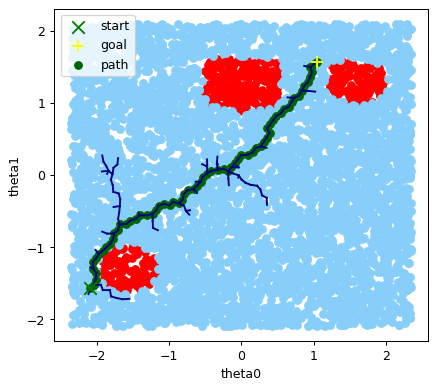

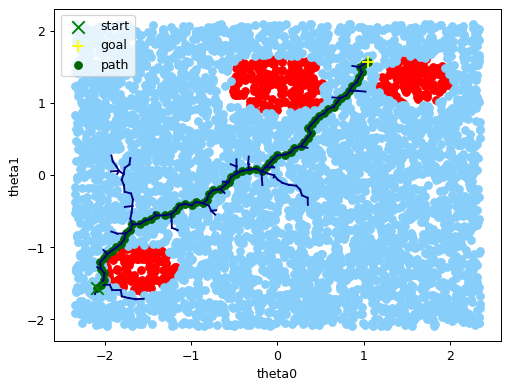

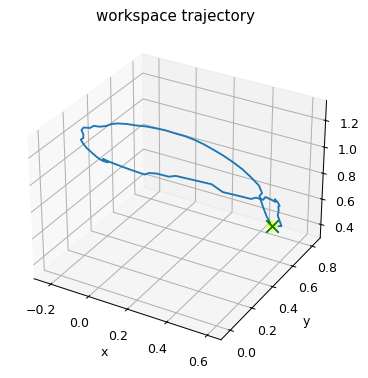

In [56]:
start = np.array([-np.pi * 2 / 3, -np.pi / 2, 0, 0, 0, 0, 0])
goal = np.array([np.pi / 3, np.pi / 2, 0, 0, 0, 0, 0])

JOINT_LIMITS = np.array([np.pi * 3/4, np.pi * 2/3, 0, 0, 0, 0, 0])
path, tree = rrt(start, goal, n=300, step_size=0.1, bias=0.2)
visualize_cspace(start, goal, path, tree)

assert not path or ((path[0] == start).all() and (path[-1] == goal).all())
visualize_cspace(start, goal, path, tree)
plot_path(path)

Increasing the bias allows us to reach the goal faster as the trees growth is directed more towards the goal. A high step size makes the tree expand more rapidly but can also cause the path to overshoot the goal or follow paths away from the goal in a more extreme way.

Now try to find a path for the situation below, in which neither joint has a joint limit. Run your planner a few different times, and again try different parameter values. Compare the variety of trees and paths that are found relative to the setup above, especially with respect to the path direction traversed from start to goal.

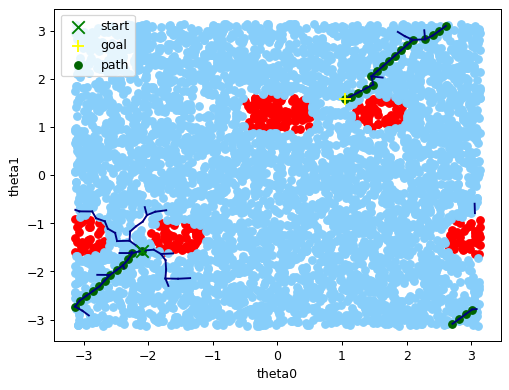

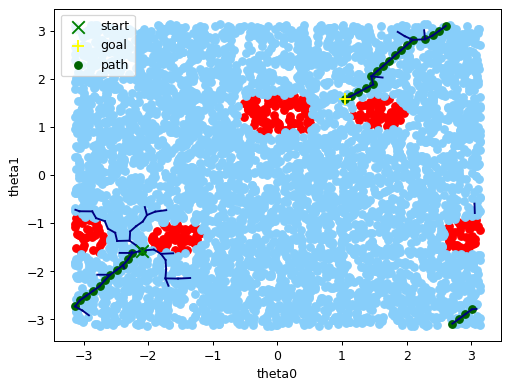

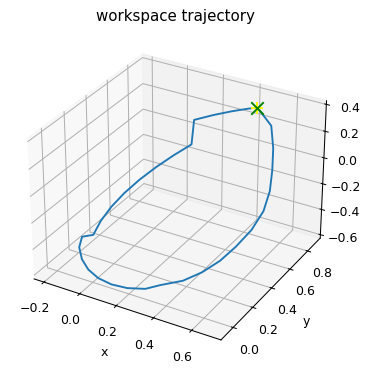

In [58]:
JOINT_LIMITS = np.array([np.pi, np.pi, 0, 0, 0, 0, 0])
path, tree = rrt(start, goal, n=300, step_size=0.2, bias=0.25)
visualize_cspace(start, goal, path, tree)

assert not path or ((path[0] == start).all() and (path[-1] == goal).all())
visualize_cspace(start, goal, path, tree)
plot_path(path)

All the paths in this example seem to "wrap around" either the theta0 or theta1 axis. They are exploiting the lack of joint limits to reach the goal as quickly as possible. 

This last simulation will allow all joints to be actuated. Since the C-space is now 7-dimensional, we can no longer visualize it. However, we can still visualize the path traversed by the robot in the workspace. 

Find a solution to the motion planning problem below. You will probably be able to solve it by just increasing the number of samples, but you can also modify the other parameters based on what you found above. If you are successful, you will see a controllable animation of frames pop up, and you can play a smooth animation as the robot moves from start to goal. 

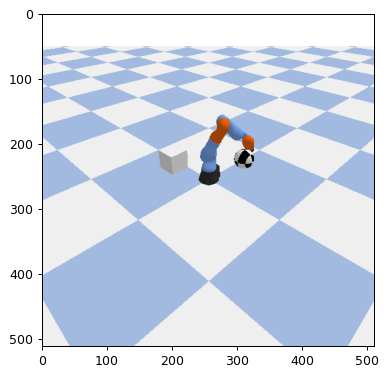

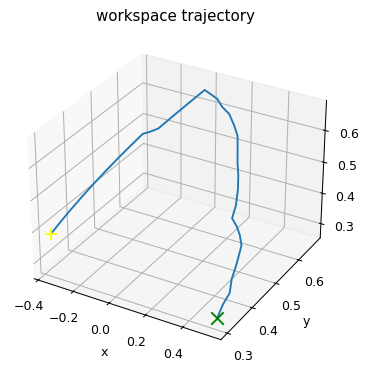

In [68]:
start = np.array([-np.pi * 5 / 6, -np.pi / 4, 0, np.pi / 2, 0, -np.pi / 8, 0])
goal = np.array([-np.pi * 3 / 8, -np.pi / 8, np.pi / 6, np.pi * 5 / 8, 0, -np.pi / 6, 0])

JOINT_LIMITS = np.array([np.pi * 3/4, np.pi * 2/3, np.pi * 3/4, np.pi * 2/3, np.pi * 3/4, np.pi * 2/3, np.pi * 3/4])
path, _ = rrt(start, goal, n=2000, step_size=0.15, bias=0.1)

assert not path or ((path[0] == start).all() and (path[-1] == goal).all())
plot_path(path)
animate_path(path)